# 

In [71]:
%matplotlib nbagg
#Import required libraries
from serial import Serial
import csv
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from drawnow import drawnow, figure
from scipy import stats
import scipy.signal as signal

In [7]:
#Functions
def initiate_reading(com,baud_rate):
    y=[]
    ser = Serial(com,baud_rate)
    time.sleep(10)
    return ser




def animate_byte(i,ser):
    b = ser.readline()# read a byte string
    string_n = b.decode()  # decode byte string into Unicode  
    string = string_n.rstrip() # remove \n and \r
    if string=='' or not string.isnumeric():
        string = '-1'
    flt = float(string)# convert string to float


    if flt !=-1:
        y.append(flt)# add to the end of data list
    ax.clear()
    ax.plot(y)



<IPython.core.display.Javascript object>


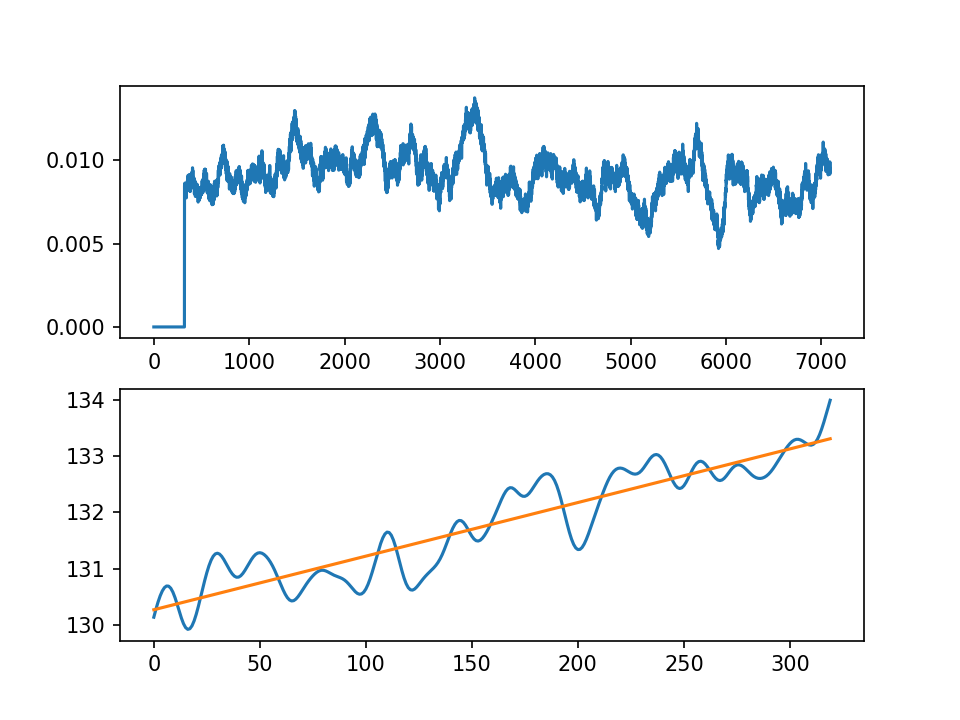

In [84]:
#Initialize arrays
y=[]
curr_slope =[]
raw_data = []
slope=[]
#Get csv array
csv_name = '\\result_light_medium.csv'
csv_path ='C:\\Users\\a_hop\\repos\\fydp-neofeed\\sensor_data'+csv_name
file = open(csv_path)
csvreader = csv.reader(file)
csv_data = np.asarray(list(csvreader))
csv_data = np.asfarray(csv_data,float).flatten()[300:]
#csv_data = csv_data.flatten().astype(float)[300:]
# fps =40
# curr_window = csv_data[-5*fps:]
# x =list(range(len(curr_window)))
# curr_slope, _, _,_,std_err = stats.linregress(x, curr_window)
# print(x)
# print(curr_slope)
def butter_filter(data, cutoff, order, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff)  # , btype='low', analog=False
#     b, a = butter(3, 0.1)
    y = filtfilt(b, a, data)
    return y

def get_filtered_signal(csv_data):
    window_width_raw = 40
    window_width_flowrate = 10
    cutoff_1 = 0.02
    order_1 = 3  # 6 # 12
    datapnt_delay = 163
    fps = 1000/datapnt_delay
 
    raw_data = []
    flow_rate = []
    flow_rate_filtered = []

    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width_raw*fps:
    curr_window_raw = raw_data[int(-window_width_raw*fps):]
    curr_window_raw_filtered = butter_filter(curr_window_raw, cutoff_1, order_1, fps)
            x =list(range(len(curr_window_raw_filtered)))
    return curr_window_raw_filtered

def get_rolling_slope(csv_data):
    window_width_raw = 40
    window_width_flowrate = 10
    cutoff_1 = 0.02
    order_1 = 3  # 6 # 12
    datapnt_delay = 163
    fps = 1000/datapnt_delay
 
    raw_data = []
    flow_rate = []
    flow_rate_filtered = []

    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width_raw*fps:
            curr_window_raw = raw_data[int(-window_width_raw*fps):]
            curr_window_raw_filtered = butter_filter(curr_window_raw, cutoff_1, order_1, fps)
            x =list(range(len(curr_window_raw_filtered)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window_raw_filtered)
            #print('curr_slope:', curr_slope)
            
            #Convert light results
            syringe_rad = 21.7/2 #Syringe radius in mm
            syringe_area = math.pi*(syringe_rad ** 2)
            conversion_factor = 0.06*fps
            curr_flowrate = curr_slope*syringe_area*conversion_factor
            flow_rate.append(curr_flowrate)
        else:
            flow_rate.append(0)
                
        cutoff_2 = 0.6
        order_2 = 6
        if len(flow_rate) > (window_width_raw+window_width_flowrate)*fps:
            curr_start = int(-window_width_flowrate*fps)
            curr_window_flowrate = flow_rate[curr_start:]
            
#             curr_window_flowrate_filtered = butter_filter(curr_window_flowrate, cutoff_2, order_2, fps)[0]
            curr_window_flowrate_filtered = np.mean(curr_window_flowrate)
            flow_rate_filtered.append(curr_window_flowrate_filtered)

        else:
            flow_rate_filtered.append(0)
    return flow_rate_filtered
#     return flow_rate

def get_rolling_slope_measured(csv_data,time):
    #Sampled every 5 seconds - real data
    fps = 1
    window_width = 3
    slope = []
    raw_data = []
    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width*fps:
            curr_window = raw_data[int(-window_width*fps):]
            x =list(range(len(curr_window)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window)
            slope.append(curr_slope)
        else:
            slope.append(0)
         
    #Calculate flow rate depending on sensor data type
    density_milk = 1 
    conversion_factor = 60
    time_interval = 5 #5s between data recordings
    flow_rate = np.multiply(slope,(1/time_interval*(1/density_milk)*conversion_factor))
    
    data_mean, data_std = np.mean(flow_rate), np.std(flow_rate)
    # identify outliers
    cut_off = data_std * 0.6
    lower, upper = data_mean - cut_off, data_mean + cut_off
    indexes_to_remove = np.where((flow_rate< lower) | (flow_rate > upper))[0]
  
    flow_rate_filtered = np.delete(flow_rate, indexes_to_remove)#indexes_to_remove[0])
    time_filtered = np.delete(np.array(time),indexes_to_remove)
        
    return flow_rate_filtered,time_filtered



def get_time(csv_data):

    datapnt_delay = 163
    fps = 1000/datapnt_delay
    time = np.multiply(range(0,len(csv_data)),(1/fps))
    return time


def process_csv(csv_path):
    file = open(csv_path)
    csvreader = csv.reader(file)
    csv_data = np.asarray(list(csvreader))
    csv_data = np.asfarray(csv_data,float).flatten()
    return csv_data

def animate(i):
    fps = 40
    val = csv_data[i]
    raw_data.append(val)
    N =3
    Wn = 0.1
    B,A = signal.butter(N,Wn,output='ba')
#     curr_smooth_data = signal.filtfilt(B,A,raw_data)
    
    
    #curr_window = raw_data[i:5*fps+i]
    #x =list(range(len(curr_window)))
    #curr_slope, _, _,_,std_err = stats.linregress(x, curr_window)
    #slope.append(curr_slope)
    window_width = 8
    if i>window_width*fps:
        curr_window = raw_data[-window_width*fps:]
        curr_smooth_data = signal.filtfilt(B,A,curr_window)
        x =list(range(len(curr_smooth_data)))
        curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_smooth_data)
        slope.append(curr_slope)
        
        def myfunc(x):
            return curr_slope * x + intercept
        mymodel = list(map(myfunc, x))
        ax[1].clear()
        ax[1].plot(curr_smooth_data)
        ax[1].plot(mymodel)
        
    else:
        slope.append(0)
        

    
    ax[0].clear()
    #ax[1].clear()
    #ax.plot(raw_data)
    ax[0].plot(slope)
    #ax[1].plot(curr_window)
    #ax[1].plot(mymodel)
#set up animation
fig,ax = plt.subplots(2,1)
anim = animation.FuncAnimation(fig,animate, frames=len(csv_data),interval = 0.000001)
plt.show()

# print (range(len(csv_data)))
# len(csv_data)

<IPython.core.display.Javascript object>


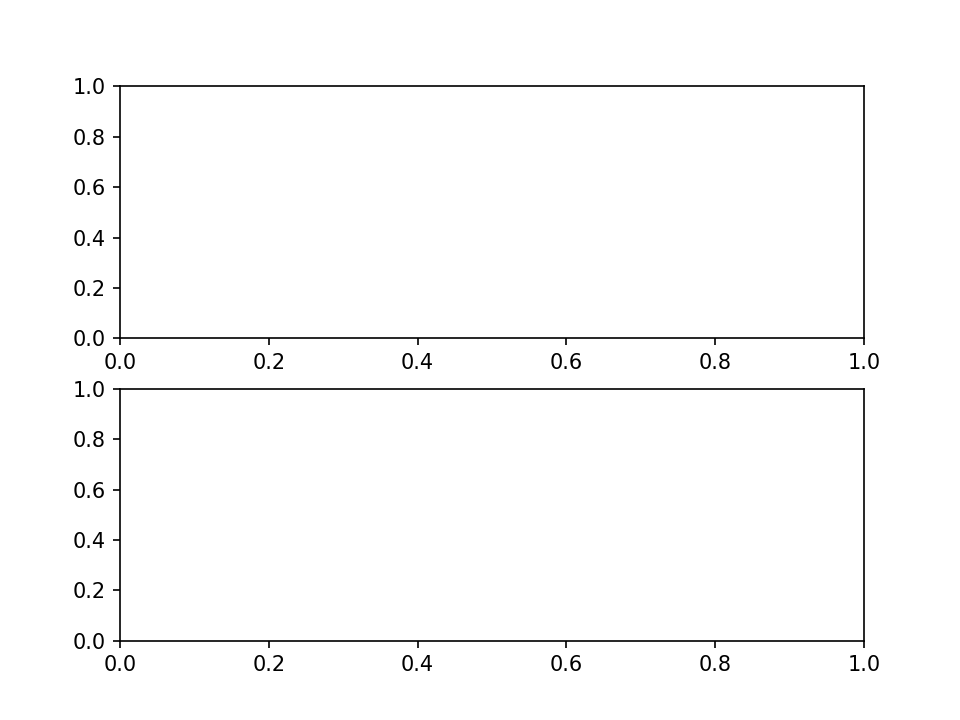

In [77]:
#Initialize arrays
y=[]
curr_slope =[]
raw_data = []
slope=[]
smooth_data =[]
#Get csv array
csv_name = '\\result_light_medium.csv'
csv_path ='C:\\Users\\a_hop\\repos\\fydp-neofeed\\sensor_data'+csv_name
file = open(csv_path)
csvreader = csv.reader(file)
csv_data = np.asarray(list(csvreader))
csv_data = np.asfarray(csv_data,float).flatten()[300:]



# N =3
# Wn = 0.1
# B,A = signal.butter(N,Wn,output='ba')
# smooth_data = signal.filtfilt(B,A,csv_data[:120])

# plt.plot(csv_data[:120])
# plt.plot(smooth_data[:120])
# plt.show()

def animate(i):
    fps = 40
    val = csv_data[i]
    raw_data.append(val)
    
    N =3
    Wn = 0.1
    B,A = signal.butter(N,Wn,output='ba')
    curr_smooth_data = signal.filtfilt(B,A,raw_data)
    
    #curr_window = raw_data[i:5*fps+i]
    #x =list(range(len(curr_window)))
    #curr_slope, _, _,_,std_err = stats.linregress(x, curr_window)
    #slope.append(curr_slope)
    window_width = 8
    if i>window_width*fps:
        curr_window = raw_data[-window_width*fps:]
        curr_smooth_data = signal.filtfilt(B,A,curr_window)
        x =list(range(len(curr_smooth_data)))
        curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_smooth_data)
        slope.append(curr_slope)
        
#         def myfunc(x):
#             return curr_slope * x + intercept
#         mymodel = list(map(myfunc, x))
#         ax[1].clear()
#         ax[1].plot(curr_window)
#         ax[1].plot(mymodel)
        
    else:
        slope.append(0)
        

    
    ax[0].clear()
    ax[1].clear()
    #ax.plot(raw_data)
    ax[0].plot(slope)
    #ax[1].plot(curr_window)
    ax[1].plot(raw_data)
#set up animation
fig,ax = plt.subplots(2,1)
anim = animation.FuncAnimation(fig,animate, frames=len(csv_data),interval = 0.02)
plt.show()

# print (range(len(csv_data)))
# len(csv_data)

# Run slope and current window with slope

<IPython.core.display.Javascript object>


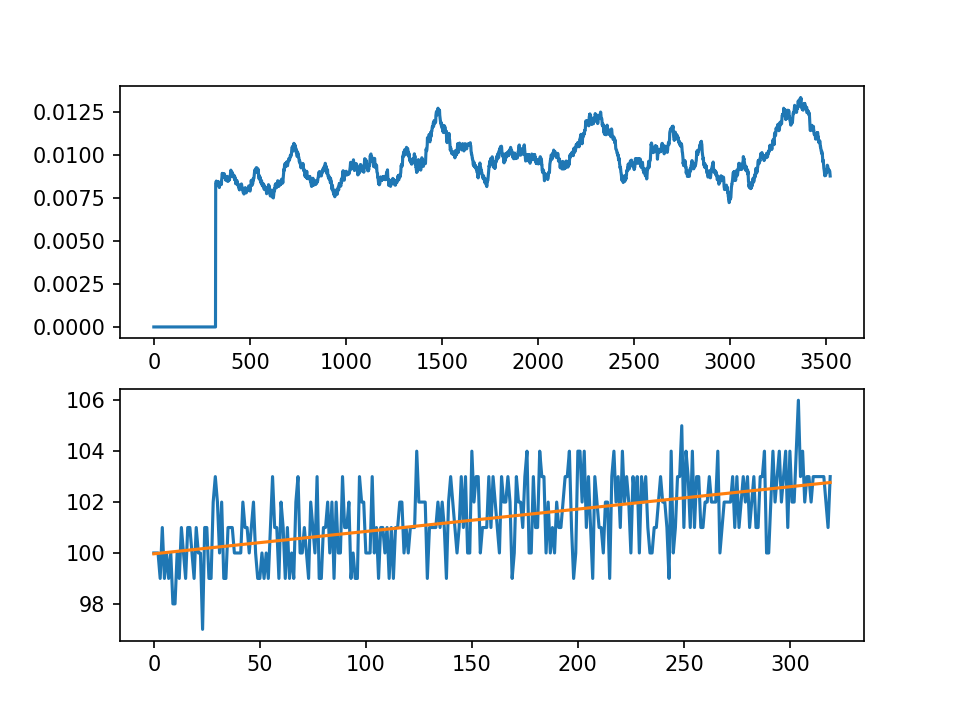

In [69]:
#Initialize arrays
y=[]
curr_slope =[]
raw_data = []
slope=[]
#Get csv array
csv_name = '\\result_light_medium.csv'
csv_path ='C:\\Users\\a_hop\\repos\\fydp-neofeed\\sensor_data'+csv_name
file = open(csv_path)
csvreader = csv.reader(file)
csv_data = np.asarray(list(csvreader))
csv_data = np.asfarray(csv_data,float).flatten()[300:]
#csv_data = csv_data.flatten().astype(float)[300:]
# fps =40
# curr_window = csv_data[-5*fps:]
# x =list(range(len(curr_window)))
# curr_slope, _, _,_,std_err = stats.linregress(x, curr_window)
# print(x)
# print(curr_slope)

def animate(i):
    fps = 40
    val = csv_data[i]
    raw_data.append(val)
    
    
    
    #curr_window = raw_data[i:5*fps+i]
    #x =list(range(len(curr_window)))
    #curr_slope, _, _,_,std_err = stats.linregress(x, curr_window)
    #slope.append(curr_slope)
    window_width = 8
    if i>window_width*fps:
        curr_window = raw_data[-window_width*fps:]
        x =list(range(len(curr_window)))
        curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window)
        slope.append(curr_slope)
        
        def myfunc(x):
            return curr_slope * x + intercept
        mymodel = list(map(myfunc, x))
        ax[1].clear()
        ax[1].plot(curr_window)
        ax[1].plot(mymodel)
        
    else:
        slope.append(0)
        

    
    ax[0].clear()
    #ax[1].clear()
    #ax.plot(raw_data)
    ax[0].plot(slope)
    #ax[1].plot(curr_window)
    #ax[1].plot(mymodel)
#set up animation
fig,ax = plt.subplots(2,1)
anim = animation.FuncAnimation(fig,animate, frames=len(csv_data),interval = 0.02)
plt.show()

# print (range(len(csv_data)))
# len(csv_data)

# PRESSURE Sensor

RUN TEST FOR HIGH HEIGHT, MEDIUM HEIGHT, LOW HEIGHT

<IPython.core.display.Javascript object>


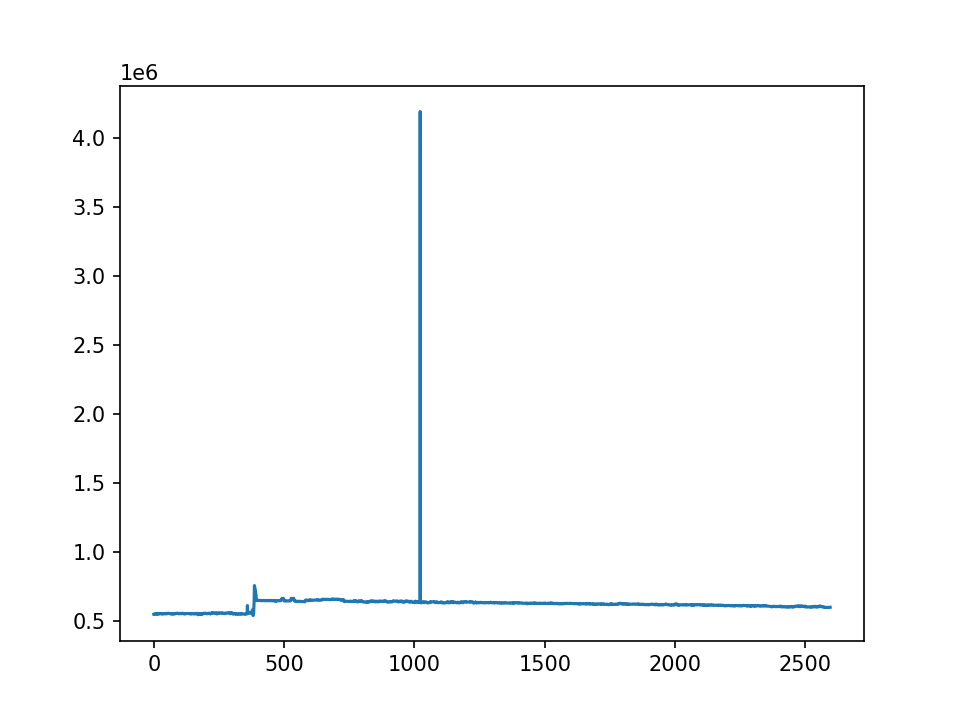

In [32]:
# Parameters
y=[]

#Initiate Reading
#ser = initiate_reading('COM3',9600)
ser = initiate_reading('COM3',57600)

# set up animation
fig,ax = plt.subplots(1, 1)
anim = animation.FuncAnimation(fig, animate_byte,fargs=(ser,),interval = 25,blit = True)
plt.show()

In [33]:
#Close Connection
ser.close()

<IPython.core.display.Javascript object>


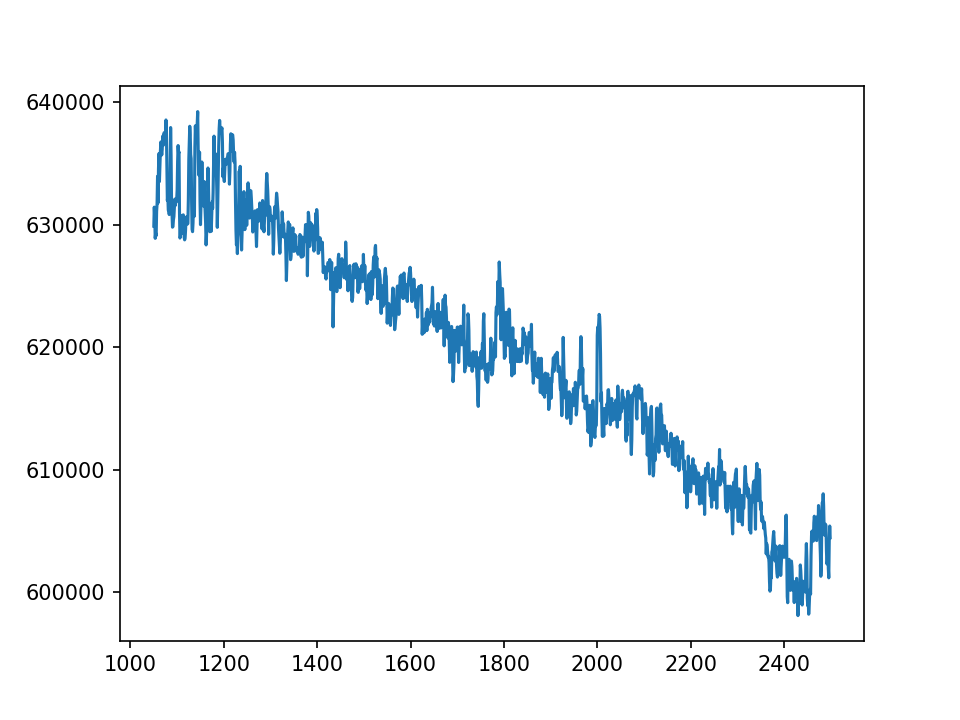

In [34]:
#Enhance graph to section we care about
i1 = 1050
i2 = 2500

fig,ax = plt.subplots(1, 1)
ax.plot(range(i1, i2, 1),y[i1:i2])
plt.show()

In [ ]:
#Get Information
i1 = int(input("Enter first index:"))
i2 = int(input("enter second index:"))

slope = (y[i2]-y[i1])/(i2-i1)
peak_value = max(y[i1:i2])
print("Slope: "+str(slope))
print("Max: "+str(peak_value))

In [ ]:
y

In [35]:
#Save this stuff
csv_name = r'\smalload_2.csv'
csv_path =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data'+csv_name

with open(csv_path, 'w',newline="") as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows([[x] for x in y])

# LIGHT SENSOR

<IPython.core.display.Javascript object>


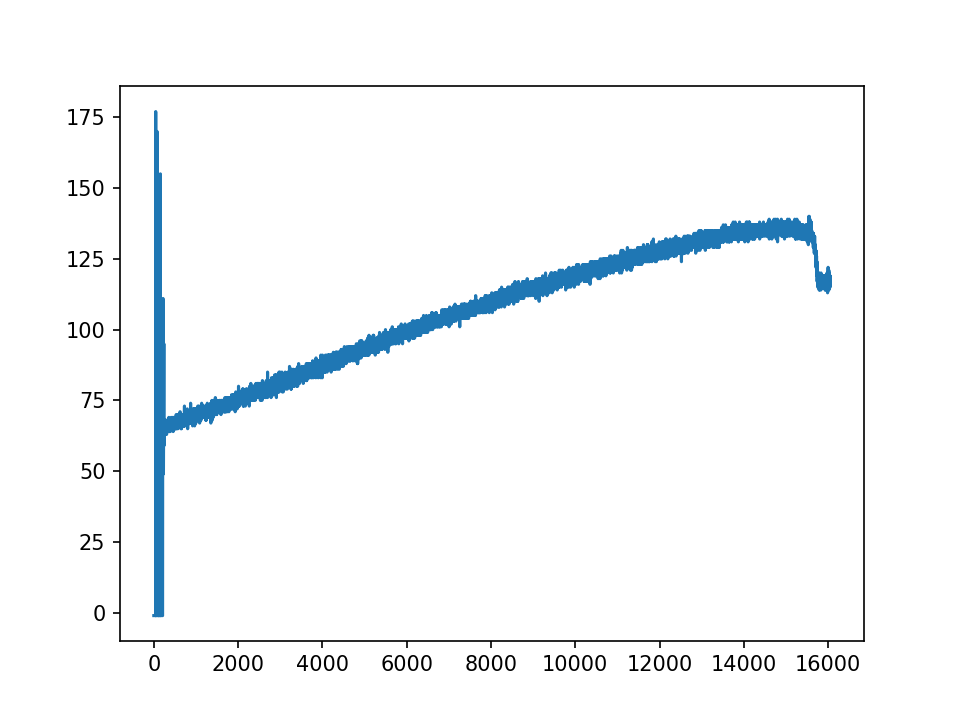

In [6]:
# Parameters
y=[]

#Initiate Reading
ser = initiate_reading('COM5',115200)

# set up animation
fig,ax = plt.subplots(1, 1)
anim = animation.FuncAnimation(fig, animate,fargs=(ser,),interval = 25,blit = True)
plt.show()

In [7]:
#Close Connection
ser.close()

In [ ]:
#Enhance graph to section we care about
i1 = int(input("Enter first index:"))
i2 = int(input("enter second index:"))

fig,ax = plt.subplots(1, 1)
ax.plot(range(i1, i2, 1),y[i1:i2])
plt.show()

In [ ]:
#Get Information
i1 = int(input("Enter first index:"))
i2 = int(input("enter second index:"))

slope = (y[i2]-y[i1])/(i2-i1)
peak_value = max(y[i1:i2])
print("Slope: "+str(slope))
print("Max: "+str(peak_value))

In [8]:
#Save this stuff
csv_name = r'\result_light_small.csv'
csv_path =r'C:\Users\a_hop\OneDrive - University of Waterloo\Year 5\Winter 2021\CAPSTONE\sensor_results'+csv_name

with open(csv_path, 'w',newline="") as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows([[x] for x in y])